In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_parquet("hf://datasets/tonyassi/celebrity-1000/data/train-00000-of-00001.parquet")

df['bytes'] = df['image'].apply(lambda x: x['bytes'])
df['path'] = df['image'].apply(lambda x: x['path'])

df = df.drop(columns=['image'])


In [56]:
df.head()

,label,bytes,path
0,0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Aaron-Eckhart0.jpg
1,0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Aaron-Eckhart1.jpg
2,0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Aaron-Eckhart10.jpg
3,0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Aaron-Eckhart11.jpg
4,0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Aaron-Eckhart12.jpg


In [57]:
import os
import re
from PIL import Image
from io import BytesIO

image_dir = "images_data"

os.makedirs(image_dir, exist_ok=True)

def convert_filename(filename):
    name_without_extension = filename.replace('.', '')[:-3]

    
    name_lower = name_without_extension.lower()
    converted_name = re.sub(r'[^a-z]+', '_', name_lower)
    
    return converted_name[:-1]

for index, row in df.iterrows():
    try:

        label_dir = os.path.join(image_dir, convert_filename(row['path']))
        os.makedirs(label_dir, exist_ok=True)

        image_filename = os.path.join(label_dir, row['path'])
        if not os.path.exists(image_filename):
            img = Image.open(BytesIO(row['bytes'])) 
            img = img.convert("RGB") 
            img.save(image_filename, "JPEG")
            print(f"Saved {image_filename}")
        df.loc[index, 'path'] = image_filename
        
    except Exception as e:
        print(f"Error saving image for row {index}: {e}")

df = df.drop(columns=['bytes']) # no longer needed
df['label'] = df['label'].astype(str) # ImageDataGenerator takes y input in type string
df.head()

,label,path
0,0,images_data/aaron_eckhart/Aaron-Eckhart0.jpg
1,0,images_data/aaron_eckhart/Aaron-Eckhart1.jpg
2,0,images_data/aaron_eckhart/Aaron-Eckhart10.jpg
3,0,images_data/aaron_eckhart/Aaron-Eckhart11.jpg
4,0,images_data/aaron_eckhart/Aaron-Eckhart12.jpg


In [58]:

train_ratio=0.8

train_df, test_df = train_test_split(df, train_size=train_ratio, stratify=df['label'])

# Duplicating pictures of Tyrone Gibson (who?) for some reason there're not put into the test ds
# Caused mismatch in shapes
df_label_954 = df[df['label'] == '954']
test_df = pd.concat([test_df, df_label_954])

train_labels = set(train_df['label'])
test_labels = set(test_df['label'])

print("Training set size:", len(train_df))
print("Test set size:", len(test_df))


Training set size: 14547
Test set size: 3640


In [59]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
rows=256  #Number of Pixels in the Rows for Input. 
cols=256  #Number of Pixels in Columns for Output

In [60]:
trained_model=MobileNetV2(input_shape=(rows,cols,3),           
                    include_top=False,
                    weights='imagenet')   


trained_model.trainable=True  #Un-Freeze all the pretrained layers of 'MobileNetV2 for Training.
    
trained_model.summary()

/tmp/ipykernel_15724/620238923.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  trained_model=MobileNetV2(input_shape=(rows,cols,3),


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [61]:
last_layer=trained_model.get_layer('out_relu')   
last_layer_output=last_layer.output  #Saves the output of the last layer of the MobileNetV2.

In [62]:
#Callback Function which stops training when accuracy reaches target %.

target_acc = 0.9

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > target_acc):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks=myCallback()

In [63]:
n_classes = 997
x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)
#Add a Dropout layer.
x = tf.keras.layers.Dropout(0.8)(x)                      
# Add a final softmax layer for classification.
x = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

model = tf.keras.Model(trained_model.input,x) 

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
#Summary of the model.
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 3,535,141 (13.49 MB)

 Trainable params: 3,501,029 (13.36 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [64]:
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)
train_datagen = ImageDataGenerator(rescale=1/255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 rotation_range=40,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)
                                 
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_dataframe(
                                                  dataframe=train_df,
                                                  target_size=(rows,cols),
                                                  x_col='path',
                                                  y_col = 'label',
                                                  class_mode='categorical')

test_generator=test_datagen.flow_from_dataframe(
                                                dataframe=test_df,
                                                target_size=(rows,cols),
                                                x_col='path',
                                                y_col = 'label',
                                                class_mode='categorical')

Found 14547 validated image filenames belonging to 997 classes.
Found 3640 validated image filenames belonging to 997 classes.


In [66]:
epochs=3

result=model.fit(train_generator,
                 validation_data=test_generator,
                 epochs=epochs,
                 callbacks=[callbacks],
                 verbose=1)

Epoch 1/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 184s 398ms/step - accuracy: 0.0026 - loss: 6.8839 - val_accuracy: 0.0060 - val_loss: 6.6793
Epoch 2/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 273s 594ms/step - accuracy: 0.0066 - loss: 6.6371 - val_accuracy: 0.0239 - val_loss: 6.1623
Epoch 3/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 220s 477ms/step - accuracy: 0.0165 - loss: 6.1785 - val_accuracy: 0.0484 - val_loss: 5.6335


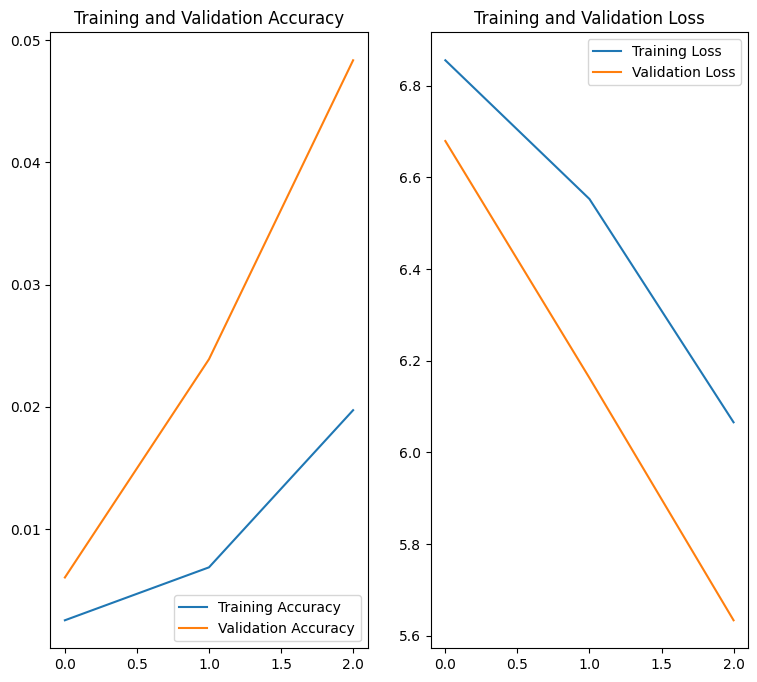

In [68]:
import matplotlib.pyplot as plt

acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [69]:
test_images = [
    'test_images/kanye_256.jpg',
    'test_images/aaron_256.jpg',
    'test_images/jolie_256.jpg',
]

classes=train_generator.class_indices
class_ids=list(classes.keys())

for image in test_images:
    

    img = tf.keras.preprocessing.image.load_img(
        image, target_size=(rows, cols)
    )

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    img_array=img_array/255.

    score = model.predict(img_array)

    print(
        "The Person in the Image is {} ."
        .format(class_ids[np.argmax(score)][5:].title())
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


NameError: name 'class_names' is not defined